In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set_theme()

In [2]:
def read_agent_example_data(*,atype,K,rho0,C0,m10,m20,P,seed,datadir):
    adata_fname = f'adata-couple-agents-example-{atype}_C0={C0}_K={K}_P={P}_m10={m10}_m20={m20}_rho0={rho0}_seed={seed}.csv'
    mdata_fname = f'mdata-couple-agents-example-{atype}_C0={C0}_K={K}_P={P}_m10={m10}_m20={m20}_rho0={rho0}_seed={seed}.csv'
    adf = pd.read_csv(datadir+adata_fname)
    mdf = pd.read_csv(datadir+mdata_fname)
    N = 2
    d = N*(K + N-1)
    adf['ln_tau'] = np.log(1.0 + adf.step)/np.log(d)
    mdf['ln_tau'] = np.log(1.0 + mdf.step)/np.log(d)
    return adf,mdf

def read_agent_stats_data(*,atype,K,rho0,C0,m10,m20,P,seed,datadir):
    adata_fname = f'adata-couple-agents-stats-{atype}_C0={C0}_K={K}_P={P}_m10={m10}_m20={m20}_rho0={rho0}.csv'
    mdata_fname = f'mdata-couple-agents-stats-{atype}_C0={C0}_K={K}_P={P}_m10={m10}_m20={m20}_rho0={rho0}.csv'
    adf = pd.read_csv(datadir+adata_fname)
    mdf = pd.read_csv(datadir+mdata_fname)
    N = 2
    d = N*(K + N-1)
    adf['ln_tau'] = np.log(1.0 + adf.step)/np.log(d)
    mdf['ln_tau'] = np.log(1.0 + mdf.step)/np.log(d)
    return adf,mdf

def load_agent_data(*,atype='ODAgent',K=5,rho0=0.5,C0=1.0,P=125,m10=0.25,m20=-0.25,seed=1234,datadir='../data/sims/N=2/'):
    exadf,exmdf = read_agent_example_data(atype=atype,K=K,rho0=rho0,C0=C0,P=P,m10=m10,m20=m20,seed=seed,datadir=datadir)
    stadf,stmdf = read_agent_stats_data(atype=atype,K=K,rho0=rho0,C0=C0,P=P,m10=m10,m20=m20,seed=seed,datadir=datadir)
    return dict(example=dict(adata=exadf,mdata=exmdf),stats=dict(adata=stadf,mdata=stmdf))

In [3]:
plotsdir = '../plots/simulations/N=2/'

In [4]:
couple_agents_datadict = load_agent_data(seed=100)

In [5]:
couple_agents_datadict['example']['adata']['eps_er'] = couple_agents_datadict['example']['adata']['id'].transform(
    lambda i: r'$\epsilon_{2|1}$' if i==1 else r'$\epsilon_{1|2}$'
)

In [17]:
sns.set_context('notebook',font_scale=1.25)

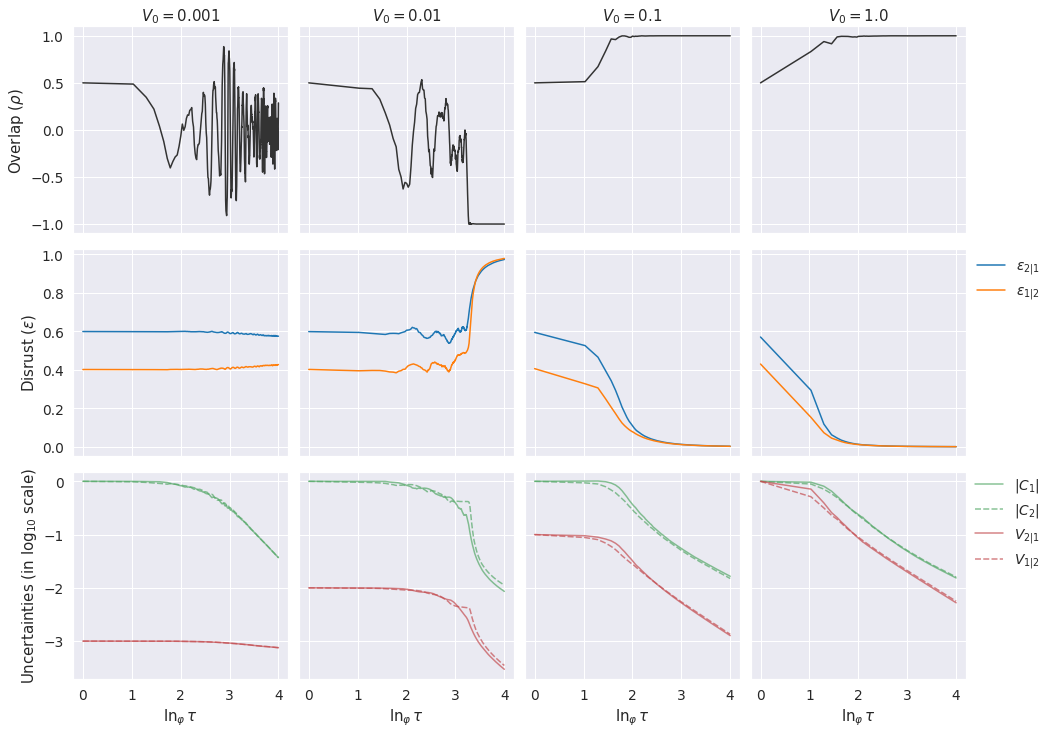

In [18]:
exfig, axes = plt.subplots(figsize=(16,12),nrows=3,ncols=4, sharey='row', sharex=True,
                           constrained_layout=False)

for (i,V0) in enumerate(np.sort(couple_agents_datadict['example']['mdata'].V0.unique())):
    adf = couple_agents_datadict['example']['adata'].query(f'V0=={V0}')
    mdf = couple_agents_datadict['example']['mdata'].query(f'V0=={V0}')
   
    rholines = sns.lineplot(
        data=mdf,x='ln_tau', y='overlap',color='#333333',
        ax=axes[0,i]
    )

    dislines = sns.lineplot(
        data=adf,x='ln_tau', y='distrust',hue='eps_er',
        palette=sns.color_palette('tab10',2),
        ax=axes[1,i], legend=(i==3)
    )
 
    Clines = sns.lineplot(
        data=adf,x='ln_tau', y='log10_norm_C',
        style='id', color='g',alpha=0.7,
        ax=axes[2,i], legend=(i==3)
    )
    
    Vlines = sns.lineplot(
        data=adf,x='ln_tau', y='log10_norm_V',
        style='id', color='r',alpha=0.7,
        ax=axes[2,i], legend=(i==3)
    )
    
    rholines.set_title('$V_0 = $'+f'{V0}')

    
exfig.subplots_adjust(wspace=0.05,hspace=0.075)    

for i in range(0,4):
    axes[2,i].set_xlabel(r'$\mathrm{ln}_{\varphi}\,\tau$')

axes[0,0].set_ylabel(r'Overlap $(\rho)$')
axes[1,0].set_ylabel(r'Disrust $(\epsilon)$')
axes[2,0].set_ylabel(r'Uncertainties (in $\mathrm{log}_{10}$ scale)')
axes[1,3].legend(loc='center right', bbox_to_anchor=(1.4, 0.85), ncol=1, frameon=False)
axes[2,3].legend([axes[2,3].lines[i] for i in [0,1,4,5]],
                 [r'$|C_1|$',r'$|C_2|$',r'$V_{2|1}$',r'$V_{1|2}$'],
                 loc='center right', bbox_to_anchor=(1.4, 0.75), ncol=1, frameon=False)

In [19]:
exfig.savefig(plotsdir+'couple-agents-example_C0=1_K=5_P=125_m10=0.25_m20=-0.25_rho0=0.5.pdf',bbox_inches='tight')

In [10]:
def concat_stats_dfs(datadict):
    adf = datadict['stats']['adata']
    mdf = datadict['stats']['mdata']
    mdf['id'] = 1
    cmdf = mdf.copy()
    cmdf['id'] = 2
    rmdf = pd.concat([mdf,cmdf]).sort_index(kind='mergesort').reset_index().drop(columns='index')
    concat_df = adf.merge(rmdf,on=adf.columns.intersection(rmdf.columns).to_list(),how='left')
    return concat_df

In [11]:
stdf = concat_stats_dfs(couple_agents_datadict)

In [20]:
sns.set_context('notebook',font_scale=1.75)

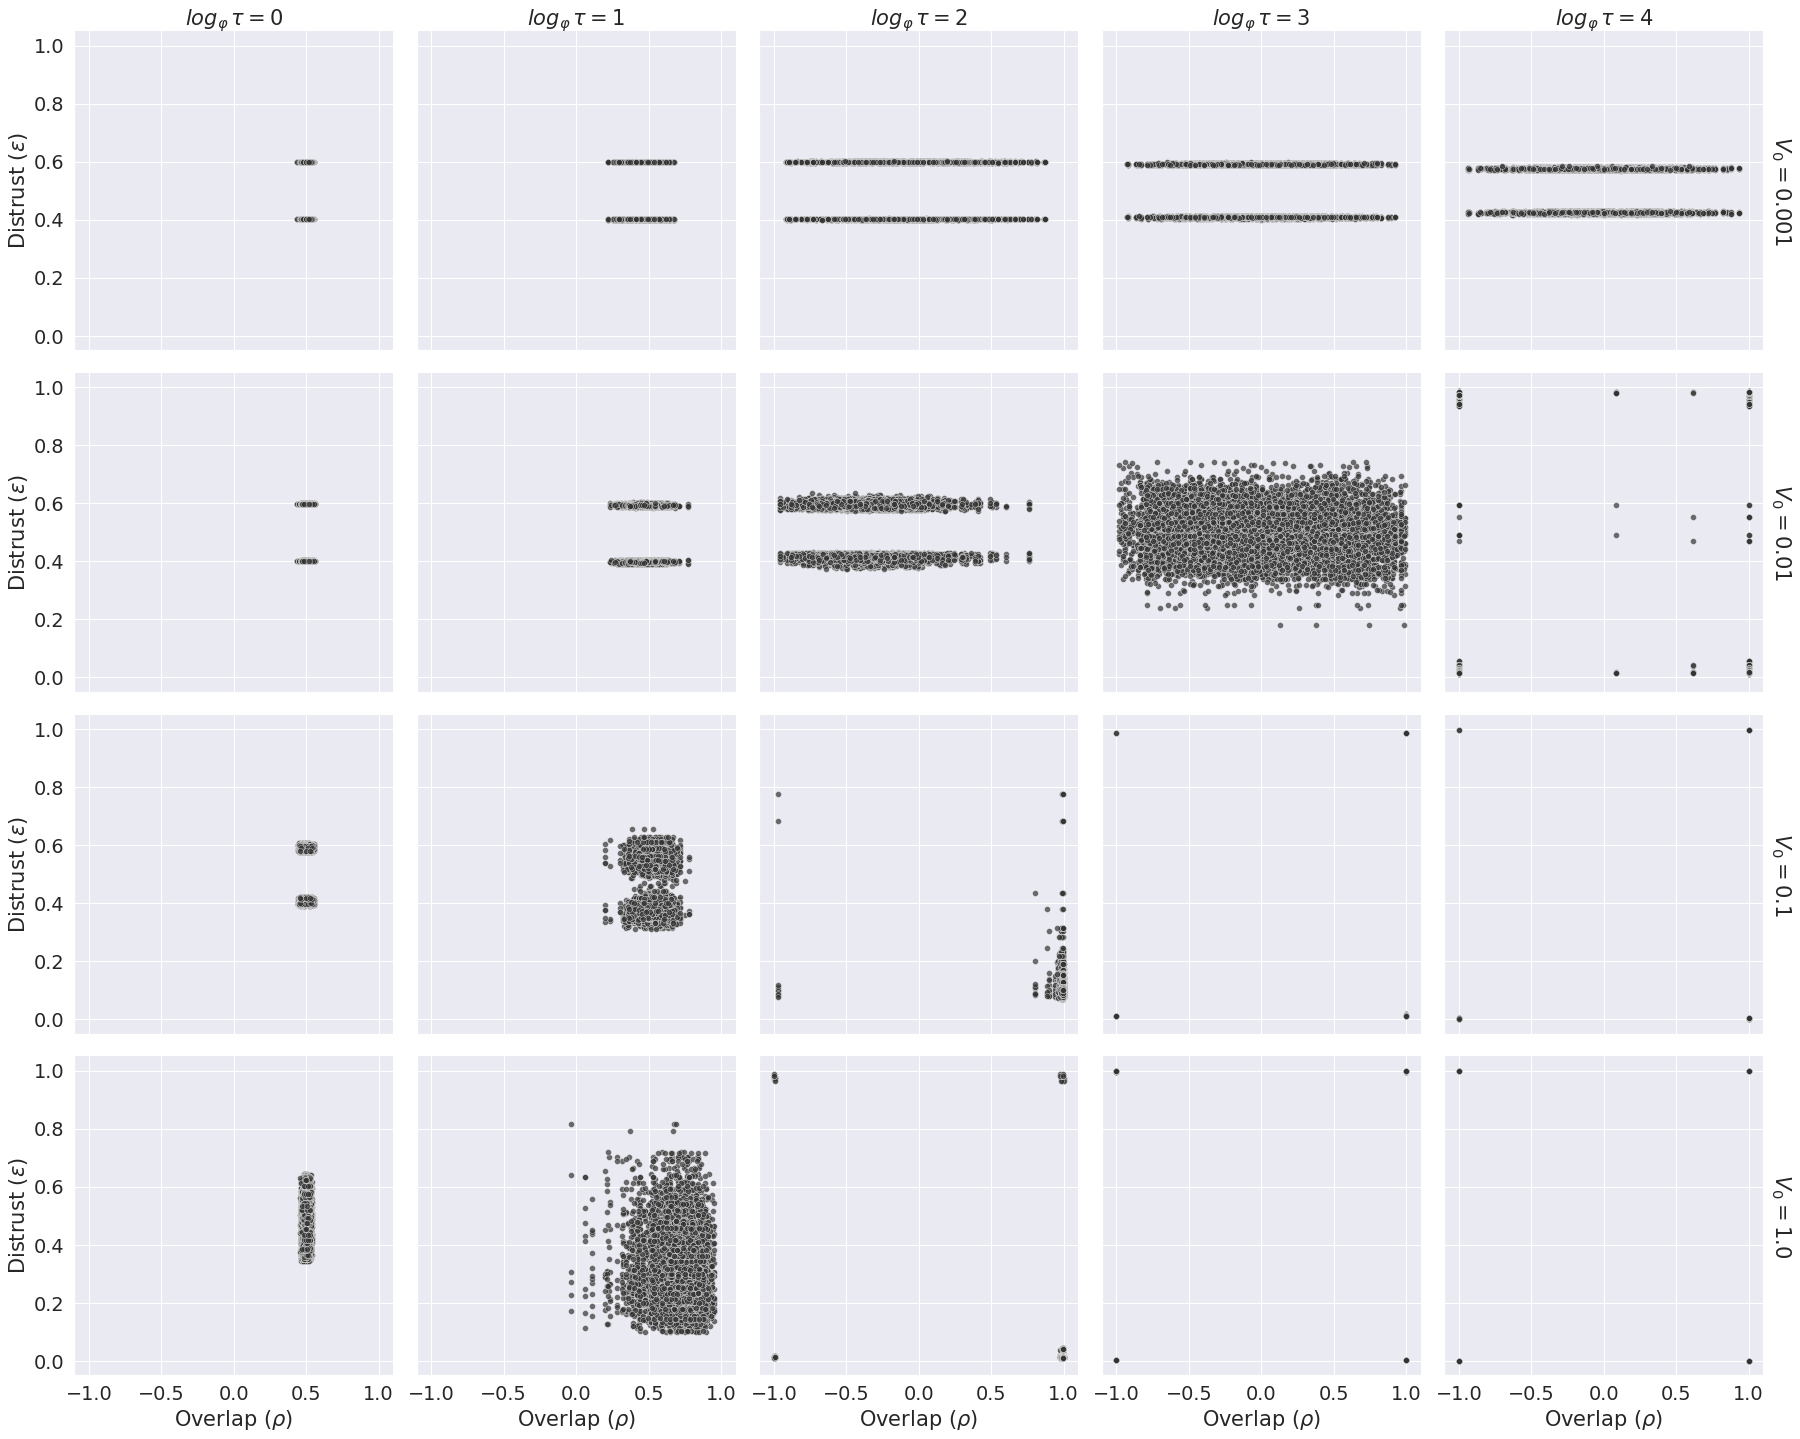

In [21]:
stfig = sns.relplot(
    data=stdf, kind='scatter',
    x='overlap', y='distrust',
    row='V0',col='ln_tau',
    color='#333333',alpha=0.7,markers='o',
    x_jitter=True,y_jitter=True,
#     stat='probability',binwidth=(0.1,0.05),common_norm=True,#common_bins=True,
#     pthresh=0.00001, pmax=.025,
    facet_kws={'margin_titles': True}, 
).set_titles(
    row_template='$V_0 = {row_name}$', 
    col_template="$log_\\varphi\\,\\tau = {col_name:.0f}$"
)

stfig.set_xlabels(r'Overlap $(\rho)$')
stfig.set_ylabels(r'Distrust $(\epsilon)$')

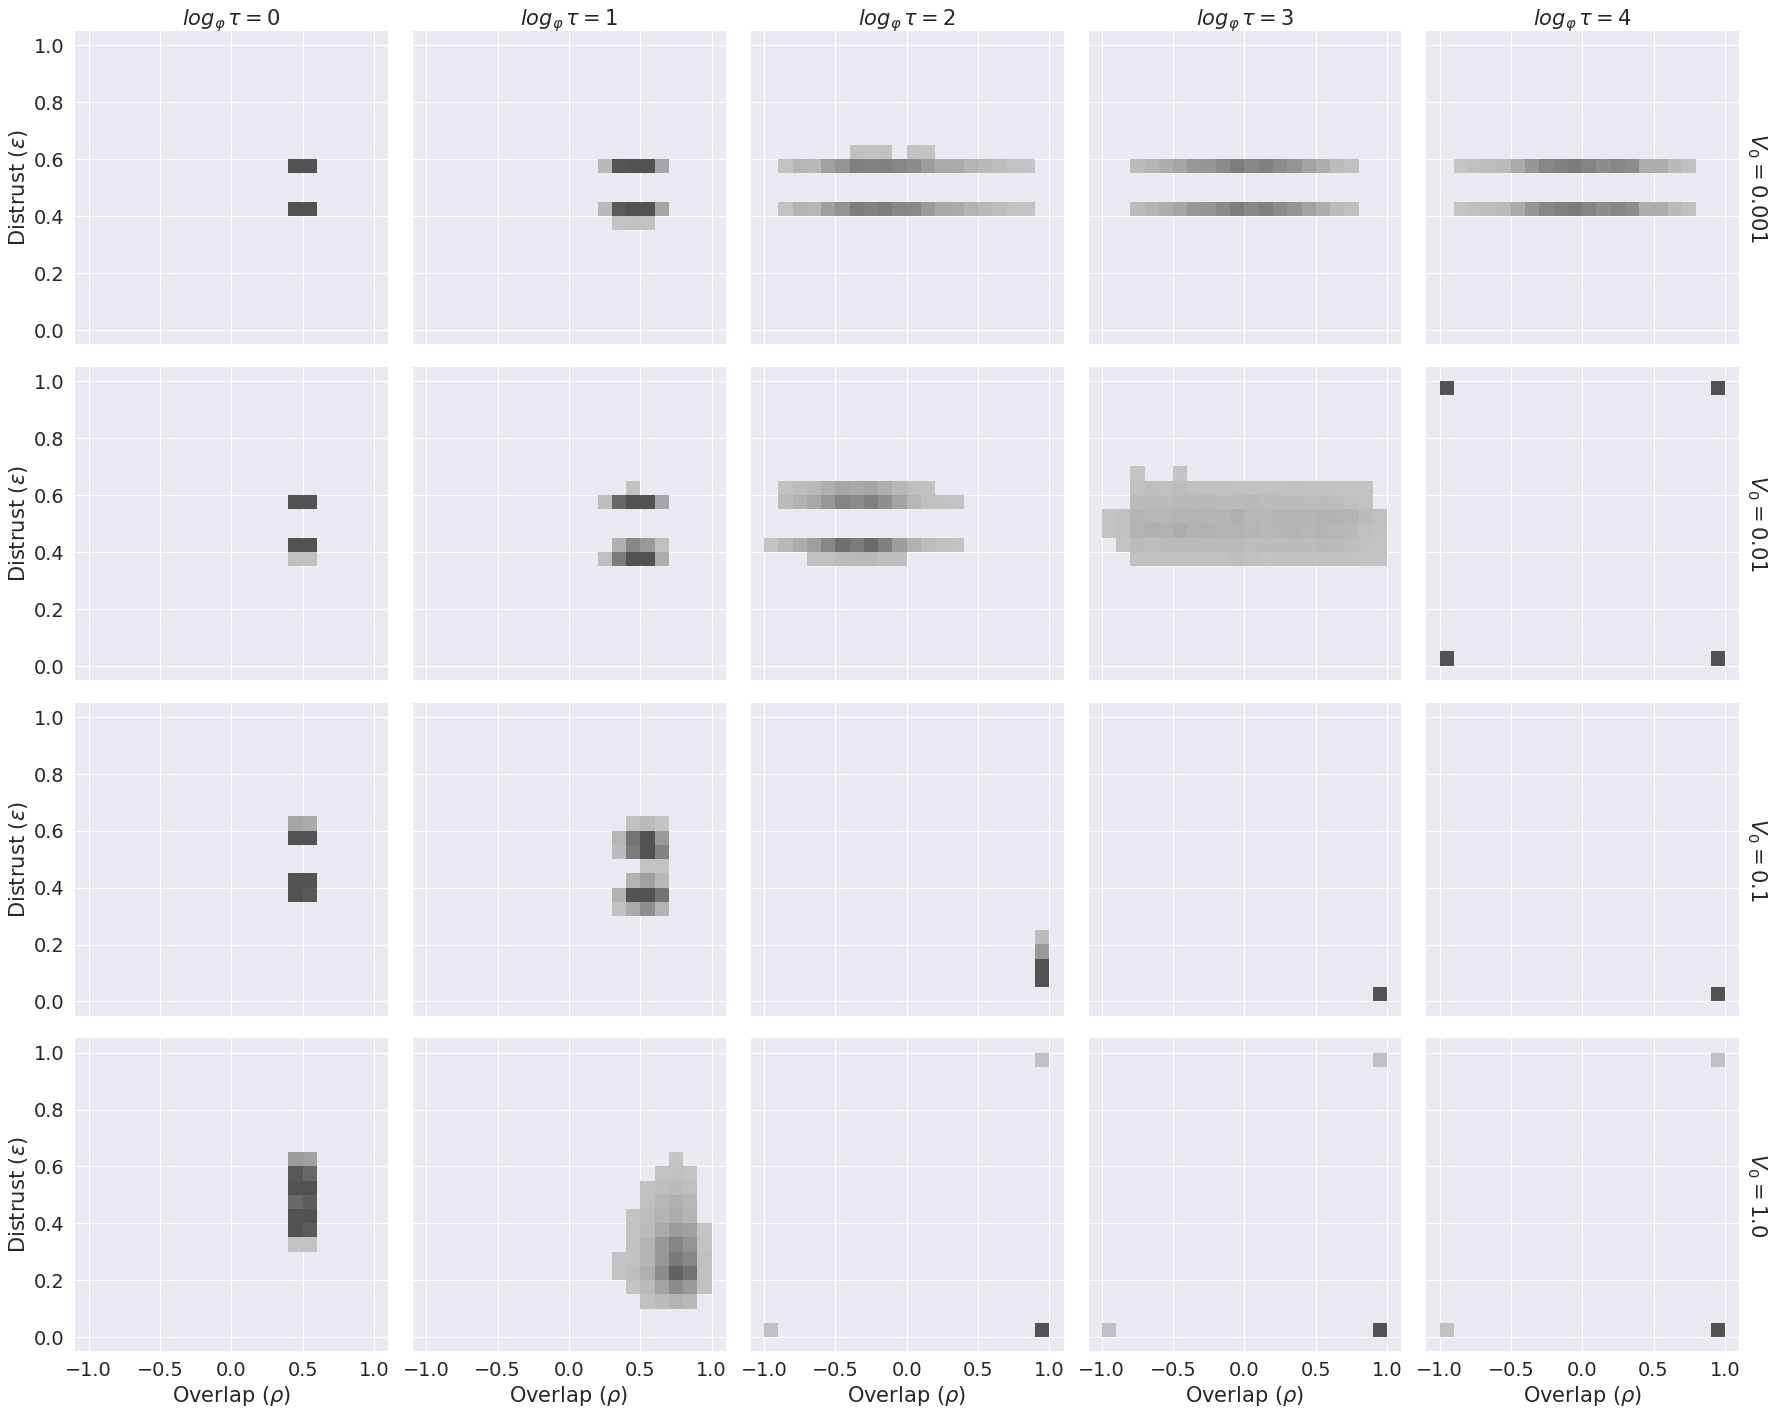

In [22]:
stfig = sns.displot(
    data=stdf, kind='hist',
    x='overlap', y='distrust',
    row='V0',col='ln_tau',
    color='#333333',#alpha=0.7,marker='o',
#     x_jitter=0.05,y_jitter=0.02,
    stat='probability',binwidth=(0.1,0.05),common_norm=True,#common_bins=True,
    pthresh=0.00001, pmax=.025,
    facet_kws={'margin_titles': True}, 
).set_titles(
    row_template='$V_0 = {row_name}$', 
    col_template="$log_\\varphi\\,\\tau = {col_name:.0f}$"
)

stfig.set_xlabels(r'Overlap $(\rho)$')
stfig.set_ylabels(r'Distrust $(\epsilon)$')

In [23]:
stfig.savefig(plotsdir+'couple-agents-stats_C0=1_K=5_P=125_m10=0.25_m20=-0.25_rho0=0.5.pdf')

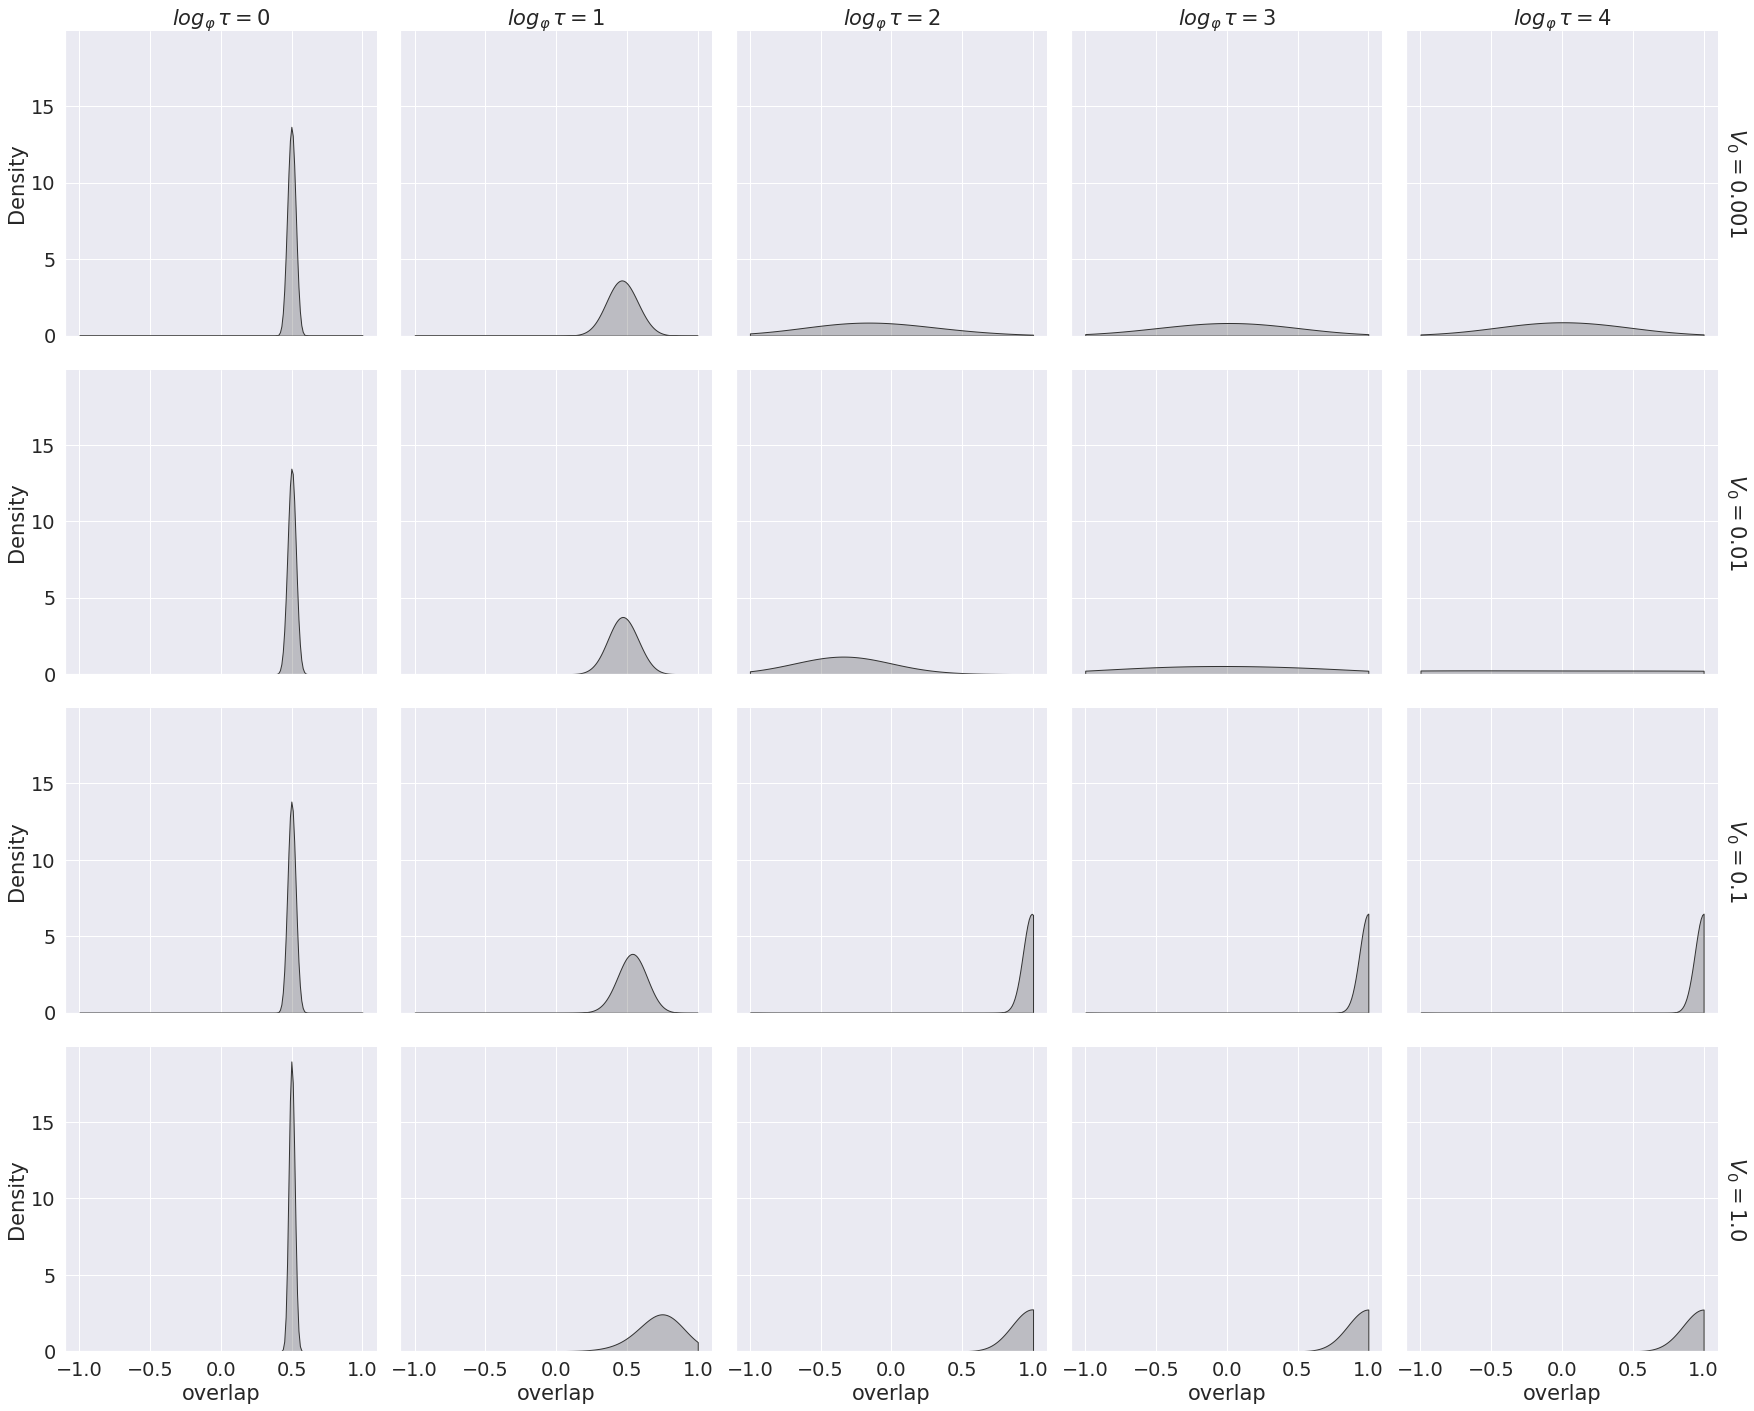

In [132]:
stfig = sns.displot(
    data=stdf, kind='kde',
    x='overlap',# y='distrust',
    row='V0',col='ln_tau',
    color='#333333',fill=True,#alpha=0.7,marker='o',
#     x_jitter=0.05,y_jitter=0.02,
#     stat='probability',binwidth=(0.1,0.05),common_norm=True,#common_bins=True,
#     pthresh=0.00001, pmax=.025,
    common_norm=False, common_grid=True, bw_adjust=4*1.5,
    clip=(-1,1),
    facet_kws={'margin_titles': True}, 
).set_titles(
    row_template='$V_0 = {row_name}$', 
    col_template="$log_\\varphi\\,\\tau = {col_name:.0f}$"
)

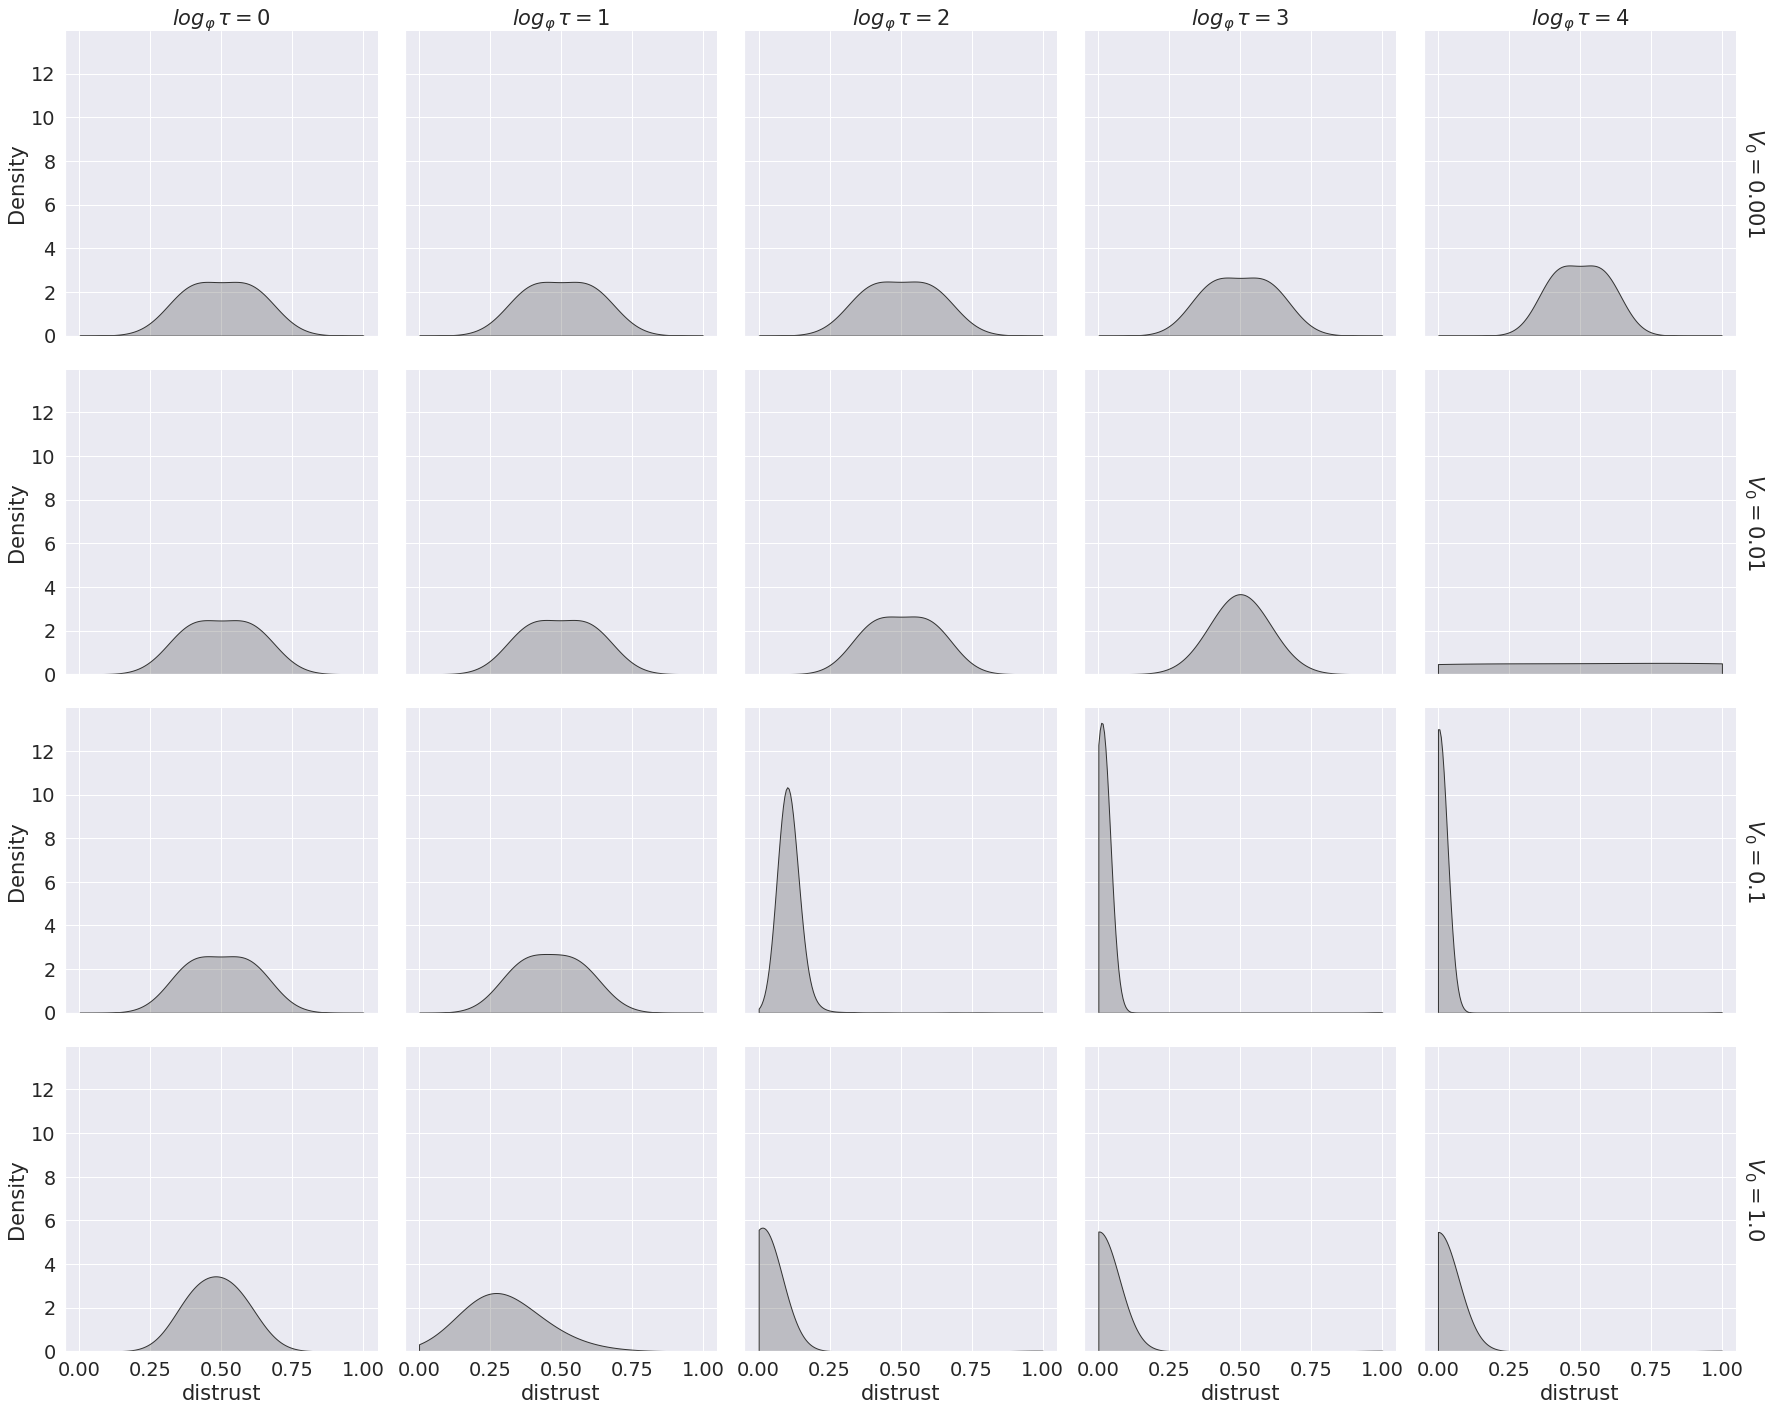

In [133]:
stfig = sns.displot(
    data=stdf, kind='kde',
    x='distrust',# y='distrust',
    row='V0',col='ln_tau',
    color='#333333',fill=True,#alpha=0.7,marker='o',
#     x_jitter=0.05,y_jitter=0.02,
#     stat='probability',binwidth=(0.1,0.05),common_norm=True,#common_bins=True,
#     pthresh=0.00001, pmax=.025,
    common_norm=False, common_grid=True, bw_adjust=4*1.5,
    clip=(0,1),
    facet_kws={'margin_titles': True}, 
).set_titles(
    row_template='$V_0 = {row_name}$', 
    col_template="$log_\\varphi\\,\\tau = {col_name:.0f}$"
)

In [117]:
sns.kdeplot?

Signature:
sns.kdeplot(
    x=None,
    *,
    y=None,
    shade=None,
    vertical=False,
    kernel=None,
    bw=None,
    gridsize=200,
    cut=3,
    clip=None,
    legend=True,
    cumulative=False,
    shade_lowest=None,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    ax=None,
    weights=None,
    hue=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    multiple='layer',
    common_norm=True,
    common_grid=False,
    levels=10,
    thresh=0.05,
    bw_method='scott',
    bw_adjust=1,
    log_scale=None,
    color=None,
    fill=None,
    data=None,
    data2=None,
    **kwargs,
)
Docstring:
Plot univariate or bivariate distributions using kernel density estimation.

A kernel density estimate (KDE) plot is a method for visualizing the
distribution of observations in a dataset, analagous to a histogram. KDE
represents the data using a continuous probability density curve in one or
more dimensions.

The approach is explained further in the :ref:`user guide 